#**Eye_classifier_pipline**

Пайплайн проекта следующий:
*   распаковка датасета
*   используя вручную размеченную часть датасета, реализуем semi-supervised подход для получения меток датасета (с помощью подхода: псевдо-лэйблинг)
*   по результатам semi-supervised выбираем наилучшее признаковое описание и метода для получения финальных псевдо-меток
*   объединение размеченных и псевдо-данных
*   реализация классификатора в виде нейросети (оформлена классом в Python)
*   тестирование, метрики, выводы







##Датасет

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import pandas

Распаковка, чтение и небольшое ознакомление с датасетом

In [2]:
zip_path = 'EyesDataset.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall('unzipped_dataset')

In [3]:
image_paths = glob.glob("unzipped_dataset/EyesDataset/*.jpg", recursive=True)

In [4]:
sizes = [cv2.imread(p).shape[:2] for p in image_paths]
heights, widths = zip(*sizes)
print("Mean height:", np.mean(heights))
print("Mean width:", np.mean(widths))

Mean height: 24.0
Mean width: 24.0


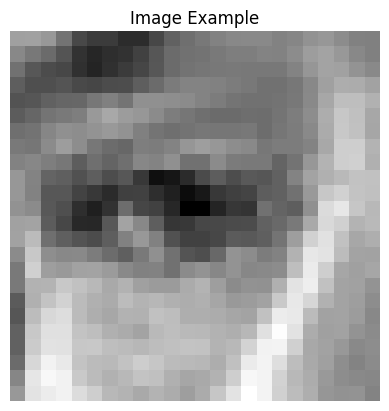

In [5]:
def preprocess_image(image_paths, size=(24, 24)):
  img = cv2.imread(image_paths)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, size)
  img = img.astype(np.float32) / 255.0
  return img

img = preprocess_image(image_paths[0])
plt.imshow(img, cmap='grey')
plt.title('Image Example')
plt.axis('off')
plt.show()

##Разметка и подготовка признаков

Разметил часть данных вручную:

In [6]:
with zipfile.ZipFile("labeled.zip", 'r') as zip_ref:
  zip_ref.extractall("labeled")

with zipfile.ZipFile("labeled_self_train.zip", 'r') as zip_ref:
  zip_ref.extractall("labeled_self_train")

Список размеченных

In [45]:
import glob
import os

# Все изображения
all_image_paths = glob.glob("unzipped_dataset/EyesDataset/*.jpg", recursive=True)

# Все размеченные — рекурсивно во всех подпапках
labeled_image_paths = glob.glob("labeled/labeled/**/*.jpg", recursive=True)
labeled_self_image_paths = glob.glob("labeled_self_train/labeled_self_train/**/*.jpg", recursive=True)
labeled_image_names = [os.path.basename(p) for p in (labeled_image_paths + labeled_self_image_paths)]

# Неразмеченные — все, кто не находится в labeled
unlabeled_image_paths = [p for p in all_image_paths if os.path.basename(p) not in labeled_image_names]

print(f"Всего изображений: {len(all_image_paths)}")
print(f"Размеченные: {len(labeled_image_paths)}")
print(f"Размеченные для self-train: {len(labeled_self_image_paths)}")
print(f"Неразмеченные: {len(unlabeled_image_paths)}")



Всего изображений: 4000
Размеченные: 636
Размеченные для self-train: 300
Неразмеченные: 3064


Обучим простой классификатор (как один из бейзлайнов):

In [46]:
from skimage.feature import hog
from skimage.feature import local_binary_pattern

Реализуем несколько вариантов признакового описания для сравнения качества работы классификатора в зависимости от признаковой предобработки:
*   Простые значения пикселей без модификаций (RAW Pixels)
*   HOG (Histogram of Oriented Gradients)
*   LBP (Local Binary Patterns)
*   Sobel (Sobel filter)

Например, в этом исследовании (по классификации глазных болезней) ипользовали схожие алгоритмы предобработки: https://ieeexplore.ieee.org/document/10710977



In [47]:
# --- RAW Pixels
def load_labeled_images_raw(folder_path, label, size=(24, 24)):
  X, y = [], []
  for fname in os.listdir(folder_path):
    path = os.path.join(folder_path, fname)
    try:
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, size)
      X.append(img.flatten())
      y.append(label)
    except:
      continue
  return X, y

# --- HOG
def load_labeled_images_hog(folder_path, label, size=(24, 24)):
  X, y = [], []
  for fname in os.listdir(folder_path):
    path = os.path.join(folder_path, fname)
    try:
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, size)
      features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
      X.append(features)
      y.append(label)
    except:
      continue
  return X, y

# --- LBP
def load_labeled_images_lbp(folder_path, label, size=(24, 24)):
  X, y = [], []
  for fname in os.listdir(folder_path):
    path = os.path.join(folder_path, fname)
    try:
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, size)
      lbp_img = local_binary_pattern(img, P=8, R=1, method="uniform")
      (hist, _) = np.histogram(lbp_img.ravel(), bins=np.arange(0, 10), range=(0, 9))
      hist = hist.astype("float")
      hist /= (hist.sum() + 1e-7)
      X.append(hist)
      y.appen(label)
    except:
      continue
  return X, y

# --- Sobel
def load_labeled_images_sobel(folder_path, label, size=(24, 24)):
  X,  y = [], []
  for fname in os.listdir(folder_path):
    path = os.path.join(folder_path, fname)
    try:
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, size)
      sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
      sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
      magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
      X.append(magnitude.flatten())
      y.append(label)
    except:
      continue
  return X, y


# --- Собираем общий features_dict
open_raw, open_labels = load_labeled_images_raw("labeled/labeled/open", 1)
closed_raw, closed_labels = load_labeled_images_raw("labeled/labeled/closed", 0)

open_hog, _ = load_labeled_images_hog("labeled/labeled/open", 1)
closed_hog, _ = load_labeled_images_hog("labeled/labeled/closed", 0)

open_lbp, _ = load_labeled_images_lbp("labeled/labeled/open", 1)
closed_lbp, _ = load_labeled_images_lbp("labeled/labeled/closed", 0)

open_sobel, _ = load_labeled_images_sobel("labeled/labeled/open", 1)
closed_sobel, _ = load_labeled_images_sobel("labeled/labeled/closed", 0)

# Объединяем ---# --- Признаковые представления
features_dict = {
    'Raw Pixels': (np.array(open_raw + closed_raw), np.array(open_labels + closed_labels)),
    'HOG': (np.array(open_hog + closed_hog), np.array(open_labels + closed_labels)),  # y тот же
    'LBP': (np.array(open_lbp + closed_lbp), np.array(open_labels + closed_labels)),
    'Sobel': (np.array(open_sobel + closed_sobel), np.array(open_labels + closed_labels))
}

In [10]:
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [48]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# --- Классификаторы
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'CatBoost': CatBoostClassifier(verbose=0),
    'LightGBM': LGBMClassifier(verbose=-1),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [50]:
# --- Метрика EER
def compute_eer(y_true, y_scores):
  fpr, tpr, threshold = roc_curve(y_true, y_scores)
  fnr = 1 - tpr
  eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  return eer, eer_threshold

##Semi-Supervised

###Тестирование на неразмеченных

In [51]:
# Неразмеченные для self-train — все, кто не находится в labeled_self_image_paths
unlabeled_self_image_paths = [p for p in all_image_paths if os.path.basename(p) not in labeled_self_image_paths]

In [52]:
from tqdm import tqdm

X_unlabeled_raw = []
X_unlabeled_hog = []
X_unlabeled_lbp = []
X_unlabeled_sobel = []

for path in tqdm(unlabeled_self_image_paths):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (24, 24))

  # Raw Pixels
  X_unlabeled_raw.append(img.flatten())

  # HOG
  fd_hog = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
  X_unlabeled_hog.append(fd_hog)

  # LBP
  lbp_img = local_binary_pattern(img, P=8, R=1, method="uniform")
  (hist_lbp, _) = np.histogram(lbp_img.ravel(), bins=np.arange(0, 10), range=(0, 9))
  hist_lbp = hist_lbp.astype("float")
  hist_lbp /= (hist_lbp.sum() + 1e-7)
  X_unlabeled_lbp.append(hist_lbp)

  # Sobel
  sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
  sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
  sobel_mag = np.sqrt(sobelx**2 + sobely**2).flatten()
  X_unlabeled_sobel.append(sobel_mag)

# Финализируем в массивы
X_unlabeled_dict = {
    'Raw Pixels': np.array(X_unlabeled_raw),
    'HOG': np.array(X_unlabeled_hog),
    'LBP': np.array(X_unlabeled_lbp),
    'Sobel': np.array(X_unlabeled_sobel)
}



100%|██████████| 4000/4000 [00:02<00:00, 1525.69it/s]


###Универсальный self-training цикл для всех признаков и всех классификаторов

In [53]:
# Загружаем маленький размеченный self-train сет
open_self_raw, open_self_labels = load_labeled_images_raw("labeled_self_train/labeled_self_train/open", 1)
closed_self_raw, closed_self_labels = load_labeled_images_raw("labeled_self_train/labeled_self_train/closed", 0)

open_self_hog, _ = load_labeled_images_hog("labeled_self_train/labeled_self_train/open", 1)
closed_self_hog, _ = load_labeled_images_hog("labeled_self_train/labeled_self_train/closed", 0)

open_self_lbp, _ = load_labeled_images_lbp("labeled_self_train/labeled_self_train/open", 1)
closed_self_lbp, _ = load_labeled_images_lbp("labeled_self_train/labeled_self_train/closed", 0)

open_self_sobel, _ = load_labeled_images_sobel("labeled_self_train/labeled_self_train/open", 1)
closed_self_sobel, _ = load_labeled_images_sobel("labeled_self_train/labeled_self_train/closed", 0)


In [54]:
features_self_train_dict = {
    'Raw Pixels': (np.array(open_self_raw + closed_self_raw), np.array(open_self_labels + closed_self_labels)),
    'HOG': (np.array(open_self_hog + closed_self_hog), np.array(open_self_labels + closed_self_labels)),
    'LBP': (np.array(open_self_lbp + closed_self_lbp), np.array(open_self_labels + closed_self_labels)),
    'Sobel': (np.array(open_self_sobel + closed_self_sobel), np.array(open_self_labels + closed_self_labels))
}

In [55]:
unlabeled_image_paths_dict = {
    feat_name: unlabeled_self_image_paths for feat_name in features_self_train_dict
}

In [56]:
def self_training_for_all(classifiers, features_dict, X_unlabeled_dict, unlabeled_image_paths_dict, threshold=0.95):
  results_self_training = {}

  for feature_name, (X_feat, y_feat) in features_dict.items():
    print(f"\n==== Feature set: {feature_name} ====")
    X_train, X_val, y_train, y_val = train_test_split(X_feat, y_feat, test_size=0.2, random_state=42)

    X_unlabeled = X_unlabeled_dict[feature_name]
    results_self_training[feature_name] = {}

    for clf_name, clf_base in classifiers.items():
      print(f"\n[Self-Training] {clf_name} on {feature_name}")

      # Создаем новый экземпляр модели
      clf = clf_base.__class__(**clf_base.get_params())
      clf.fit(X_train, y_train)

      # Предсказание на неразмеченой
      y_unlabeled_proba = clf.predict_proba(X_unlabeled)
      y_unlabeled_pred = np.argmax(y_unlabeled_proba, axis=1)
      max_proba = np.max(y_unlabeled_proba, axis=1)

      # Отбор уверенных
      mask_confident = max_proba > threshold
      X_pseudo = X_unlabeled[mask_confident]
      y_pseudo = y_unlabeled_pred[mask_confident]

      print(f"[INFO] Уверенных примеров добавлено: {len(y_pseudo)}")

      # Объединение и повторное обучение
      X_combined = np.vstack([X_train, X_pseudo])
      y_combined = np.hstack([y_train, y_pseudo])

      clf_retrained = clf_base.__class__(**clf_base.get_params())
      clf_retrained.fit(X_combined, y_combined)

      # Проверка на валидации
      y_val_pred = clf_retrained.predict(X_val)
      y_val_proba = clf_retrained.predict_proba(X_val)[:, 1]

      acc = accuracy_score(y_val, y_val_pred)
      auc = roc_auc_score(y_val, y_val_proba)
      eer, _ = compute_eer(y_val, y_val_proba)

      print(f"[RESULT] After Self-training - Accuracy {acc:.4f}, AUC: {auc:.4f}, EER: {eer:.4f}")
      print(classification_report(y_val, y_val_pred))

      confident_paths = np.array(unlabeled_image_paths_dict[feature_name])[mask_confident]
      confident_labels = y_unlabeled_pred[mask_confident]

      results_self_training[feature_name][clf_name] = {
          'accuracy': acc,
          'auc': auc,
          'eer': eer,
          'added_pseudo_labels': len(y_pseudo),
          'confident_paths': confident_paths,
          'confident_labels': confident_labels
      }

  return results_self_training

In [57]:
results_self_training = self_training_for_all(
    classifiers=classifiers,
    features_dict=features_self_train_dict,  # <--- маленький self-train set!
    X_unlabeled_dict=X_unlabeled_dict,
    unlabeled_image_paths_dict=unlabeled_image_paths_dict,
    threshold=0.95
)



==== Feature set: Raw Pixels ====

[Self-Training] Logistic Regression on Raw Pixels
[INFO] Уверенных примеров добавлено: 3647
[RESULT] After Self-training - Accuracy 0.8500, AUC: 0.9344, EER: 0.1290
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        31
           1       0.88      0.79      0.84        29

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


[Self-Training] SVM on Raw Pixels
[INFO] Уверенных примеров добавлено: 537
[RESULT] After Self-training - Accuracy 0.7167, AUC: 0.8065, EER: 0.3226
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        31
           1       0.69      0.76      0.72        29

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.72      0.72      0.72        

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[INFO] Уверенных примеров добавлено: 2806


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[RESULT] After Self-training - Accuracy 0.8000, AUC: 0.8331, EER: 0.1935
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        31
           1       0.77      0.83      0.80        29

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60


[Self-Training] KNN on Raw Pixels
[INFO] Уверенных примеров добавлено: 1295
[RESULT] After Self-training - Accuracy 0.6500, AUC: 0.6407, EER: 0.3871
              precision    recall  f1-score   support

           0       0.63      0.77      0.70        31
           1       0.68      0.52      0.59        29

    accuracy                           0.65        60
   macro avg       0.66      0.65      0.64        60
weighted avg       0.66      0.65      0.64        60


==== Feature set: HOG ====

[Self-Training] Logistic Regression on HOG
[INFO] Уверенных примеров добавлено: 550
[RESULT] A

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[RESULT] After Self-training - Accuracy 0.8500, AUC: 0.9333, EER: 0.1290
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        31
           1       0.81      0.90      0.85        29

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


[Self-Training] KNN on HOG
[INFO] Уверенных примеров добавлено: 2280
[RESULT] After Self-training - Accuracy 0.9333, AUC: 0.9761, EER: 0.0323
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        31
           1       0.88      1.00      0.94        29

    accuracy                           0.93        60
   macro avg       0.94      0.94      0.93        60
weighted avg       0.94      0.93      0.93        60


==== Feature set: LBP ====

[Self-Training] Logistic Regression on LBP
[INFO] Уверенных примеров добавлено: 0
[RESULT] After Self

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[INFO] Уверенных примеров добавлено: 3636
[RESULT] After Self-training - Accuracy 0.8333, AUC: 0.8749, EER: 0.1935
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        31
           1       0.88      0.76      0.81        29

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60


[Self-Training] SVM on Sobel
[INFO] Уверенных примеров добавлено: 528
[RESULT] After Self-training - Accuracy 0.7833, AUC: 0.8743, EER: 0.1935
              precision    recall  f1-score   support

           0       0.80      0.77      0.79        31
           1       0.77      0.79      0.78        29

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60


[Self-Training] CatBoost on Sobel
[INFO] Уверенных примеров добавлено: 241
[RESULT] Af

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[INFO] Уверенных примеров добавлено: 1979
[RESULT] After Self-training - Accuracy 0.7167, AUC: 0.8065, EER: 0.2903
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        31
           1       0.71      0.69      0.70        29

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.72      0.72      0.72        60


[Self-Training] KNN on Sobel
[INFO] Уверенных примеров добавлено: 1137
[RESULT] After Self-training - Accuracy 0.7667, AUC: 0.8604, EER: 0.1935
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        31
           1       0.80      0.69      0.74        29

    accuracy                           0.77        60
   macro avg       0.77      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [58]:
pseudo_paths = []
pseudo_labels = []

for clf_results in results_self_training.values():
    for clf_name, metrics in clf_results.items():
        if 'confident_paths' in metrics:
            pseudo_paths.extend(metrics['confident_paths'])
            pseudo_labels.extend(metrics['confident_labels'])

# Удалим дубликаты (если модели дали одинаковые confident-предсказания)
from collections import defaultdict
confident_dict = defaultdict(list)
for path, label in zip(pseudo_paths, pseudo_labels):
    confident_dict[path].append(label)

# Мажоритарное голосование
final_pseudo_paths = []
final_pseudo_labels = []
for path, labels in confident_dict.items():
    final_pseudo_paths.append(path)
    final_pseudo_labels.append(int(np.round(np.mean(labels))))

# Сохраняем как списки
pseudo_paths = final_pseudo_paths
pseudo_labels = final_pseudo_labels

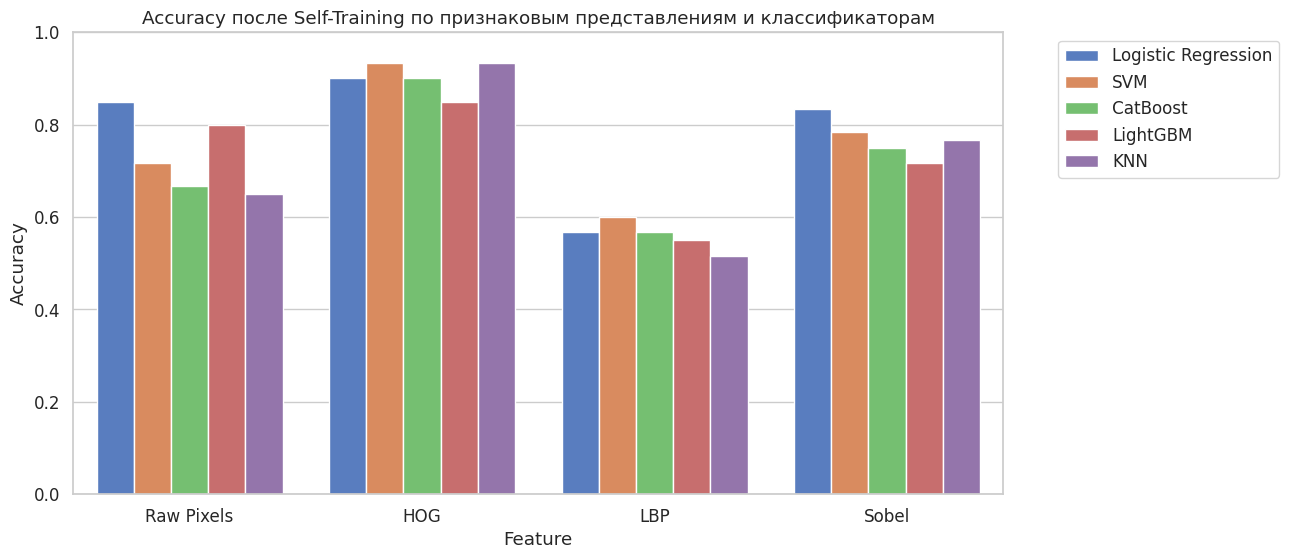

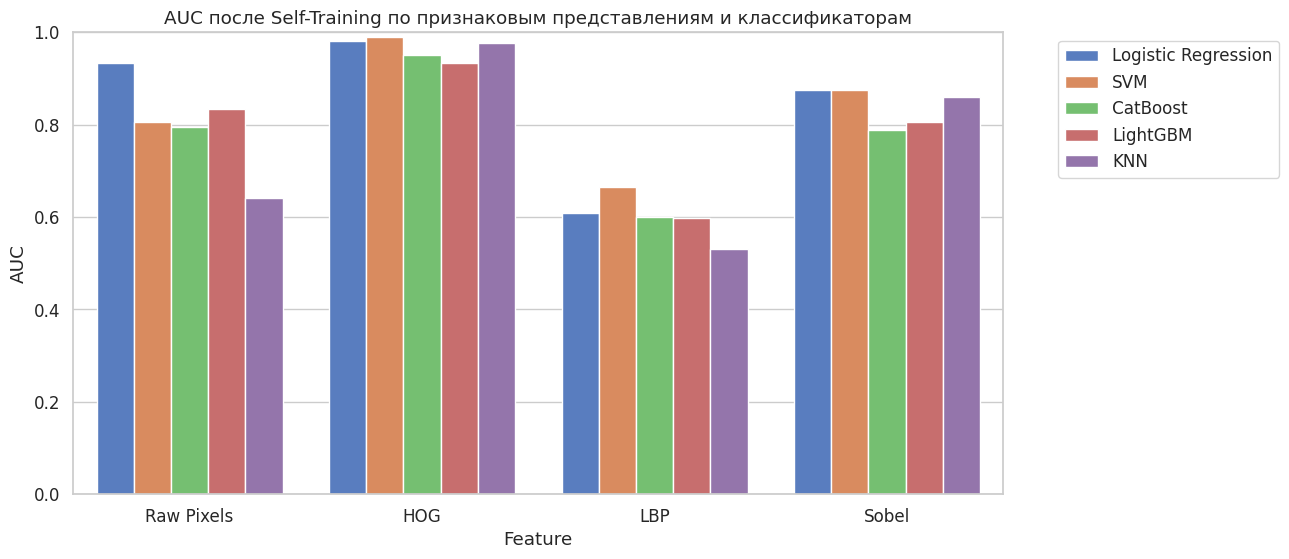

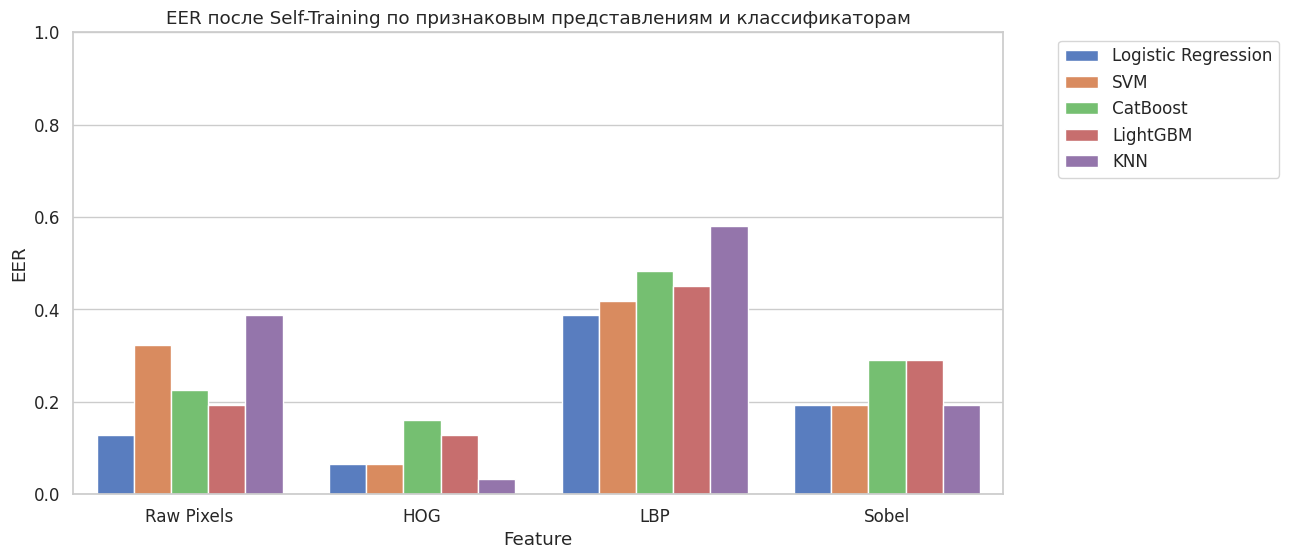

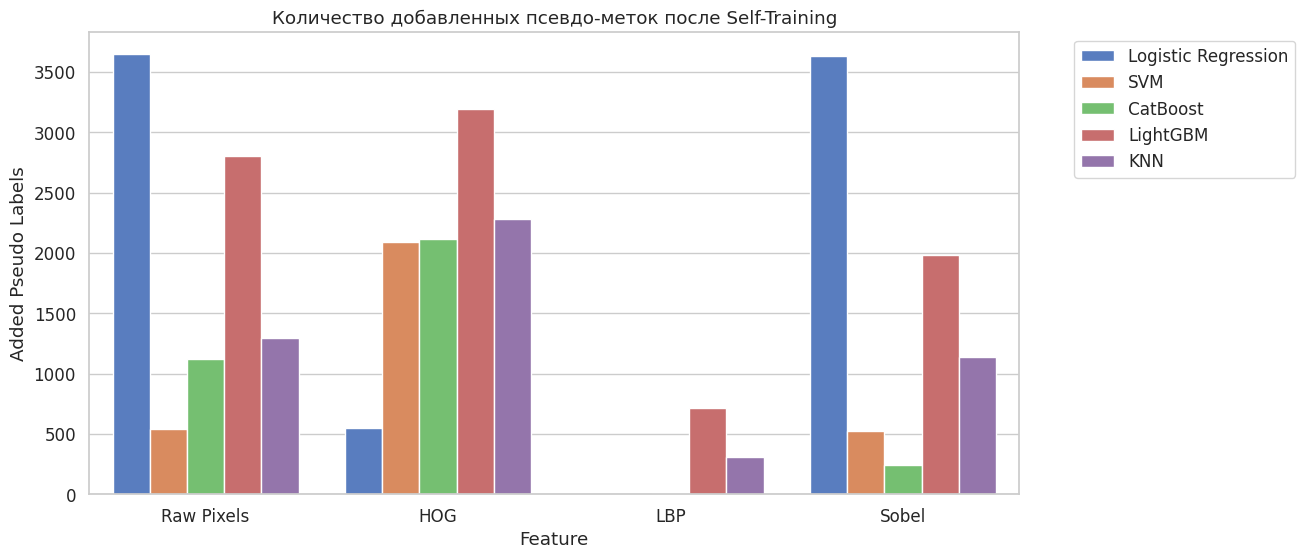

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Преобразование self-training результатов в DataFrame ---
rows_self = []
for feature_name, clf_results in results_self_training.items():
    for clf_name, metrics in clf_results.items():
        row = {
            'Feature': feature_name,
            'Classifier': clf_name,
            'Accuracy': metrics['accuracy'],
            'AUC': metrics['auc'],
            'EER': metrics['eer'],
            'Added Pseudo Labels': metrics['added_pseudo_labels']
        }
        rows_self.append(row)

results_self_df = pd.DataFrame(rows_self)

# --- Визуализация ---
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# --- Accuracy ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_self_df, x='Feature', y='Accuracy', hue='Classifier')
plt.title('Accuracy после Self-Training по признаковым представлениям и классификаторам')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- AUC ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_self_df, x='Feature', y='AUC', hue='Classifier')
plt.title('AUC после Self-Training по признаковым представлениям и классификаторам')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- EER (чем меньше, тем лучше)
plt.figure(figsize=(12, 6))
sns.barplot(data=results_self_df, x='Feature', y='EER', hue='Classifier')
plt.title('EER после Self-Training по признаковым представлениям и классификаторам')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- Добавленные псевдо-метки ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_self_df, x='Feature', y='Added Pseudo Labels', hue='Classifier')
plt.title('Количество добавленных псевдо-меток после Self-Training')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [23]:
best_feature = 'HOG'
best_classifier = {'SVM': classifiers['SVM']}

results_self_training = self_training_for_all(
    classifiers=best_classifier,
    features_dict={best_feature: features_self_train_dict[best_feature]},
    X_unlabeled_dict={best_feature: X_unlabeled_dict[best_feature]},
    unlabeled_image_paths_dict={best_feature: unlabeled_image_paths_dict[best_feature]},
    threshold=0.95
)



==== Feature set: HOG ====

[Self-Training] SVM on HOG
[INFO] Уверенных примеров добавлено: 2177
[RESULT] After Self-training - Accuracy 0.9500, AUC: 0.9889, EER: 0.0645
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        31
           1       0.93      0.97      0.95        29

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [24]:
hog_results = results_self_training['HOG']['SVM']
pseudo_paths = hog_results['confident_paths']
pseudo_labels = hog_results['confident_labels']


##Нейросеть

In [31]:
print("len(labeled_paths):", len(labeled_paths))
print("len(labeled_labels):", len(labeled_labels))
print("len(pseudo_paths):", len(pseudo_paths))
print("len(pseudo_labels):", len(pseudo_labels))


len(labeled_paths): 300
len(labeled_labels): 300
len(pseudo_paths): 2177
len(pseudo_labels): 2177


In [26]:
# Списки путей
all_imgs  = glob.glob("dataset/EyesDataset/*.jpg", recursive=True)
labeled_paths = glob.glob("labeled_self_train/labeled_self_train/**/*.jpg", recursive=True)

# Метки по папке: '.../open/...' → 1, иначе 0
def get_label(path):
    return 1 if os.path.basename(os.path.dirname(path)) == "open" else 0

labeled_labels = [get_label(p) for p in labeled_paths]

# Добавляем confident-псевдоразметку
all_labeled = labeled_paths + list(pseudo_paths)
y_all = np.array(labeled_labels + list(pseudo_labels), dtype=np.int32)

In [27]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    horizontal_flip=True
)


class OpenEyesTrainer:
    def __init__(self, use_pseudo_labels=True, image_size=(224, 224)):
        self.use_pseudo_labels = use_pseudo_labels
        self.image_size = image_size
        self.model = None
        self.val_paths = []
        self.y_val = []

        self.labeled_paths = glob("labeled_self_train/labeled_self_train/**/*.jpg", recursive=True)
        self.labeled_labels = [self.get_label(p) for p in self.labeled_paths]

        self.pseudo_paths = []  # Добавляются через set_pseudo_labels()
        self.pseudo_labels = []

    def set_pseudo_labels(self, paths, labels):
        self.pseudo_paths = list(paths)
        self.pseudo_labels = list(labels)

    def get_label(self, path):
        return 1 if os.path.basename(os.path.dirname(path)) == "open" else 0

    def load_images(self, paths):
        X = []
        for p in paths:
            img = cv2.imread(p)
            if img is None:
                print(f"[WARNING] Can't read: {p}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.image_size).astype(np.float32) / 255.0
            X.append(img)
        return np.stack(X)


    def image_generator(paths, labels, image_size, batch_size):
        def load_img(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, image_size)
            img = tf.cast(img, tf.float32) / 255.0
            return img, label

        dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
        dataset = dataset.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    def build_model(self):
        base = MobileNetV2(input_shape=(*self.image_size, 3), include_top=False, weights="imagenet")
        x = GlobalAveragePooling2D()(base.output)
        x = Dropout(0.3)(x)
        out = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=base.input, outputs=out)
        for layer in base.layers:
            layer.trainable = False
        model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
        return model

    def train(self, epochs=30, batch_size=32):
        # Объединение размеченных и псевдоразмеченных
        all_paths = self.labeled_paths.copy()
        all_labels = self.labeled_labels.copy()
        if self.use_pseudo_labels and self.pseudo_paths:
            all_paths += self.pseudo_paths
            all_labels += self.pseudo_labels

        y_all = np.array(all_labels, dtype=np.int32)

        paths_train, paths_val, y_train, y_val = train_test_split(
            all_paths, y_all, test_size=0.2, stratify=y_all, random_state=42
        )

        self.val_paths = paths_val  # сохраняем для оценки
        self.y_val = y_val

        X_train = self.load_images(paths_train)
        X_val = self.load_images(paths_val)

        self.model = self.build_model()
        self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=2
        )

        print("[INFO] Обучение завершено.")

    def predict_proba(self, path):
        img = cv2.imread(path)
        if img is None:
            print(f"[ERROR] Can't read image: {path}")
            return 0.0
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.image_size).astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)
        return float(self.model.predict(img, verbose=0)[0, 0])

    def compute_eer(self, y_true, y_scores):
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        fnr = 1 - tpr
        abs_diffs = np.abs(fpr - fnr)
        idx = np.nanargmin(abs_diffs)
        eer = fpr[idx]
        threshold = thresholds[idx]
        return eer, threshold

    def evaluate(self):
        if self.model is None or not self.val_paths:
            print("[ERROR] Модель не обучена или нет валидационного сета")
            return

        y_scores = [self.predict_proba(p) for p in self.val_paths]
        eer, thr = self.compute_eer(self.y_val, y_scores)

        y_pred = [1 if s >= thr else 0 for s in y_scores]
        acc = accuracy_score(self.y_val, y_pred)
        print(f"\n[RESULTS] EER: {eer:.4f}, Threshold: {thr:.4f}, Accuracy: {acc:.4f}")
        print(classification_report(self.y_val, y_pred))

        # ROC-кривая
        fpr, tpr, _ = roc_curve(self.y_val, y_scores)
        auc = np.trapz(tpr, fpr)
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    def save(self, path="open_eyes_model.h5"):
        if self.model:
            self.model.save_weights(path)
            print(f"[INFO] Сохранено: {path}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
62/62 - 106s - 2s/step - accuracy: 0.8905 - loss: 0.3195 - val_accuracy: 0.9395 - val_loss: 0.1962
Epoch 2/15
62/62 - 94s - 2s/step - accuracy: 0.9576 - loss: 0.1595 - val_accuracy: 0.9476 - val_loss: 0.1456
Epoch 3/15
62/62 - 143s - 2s/step - accuracy: 0.9611 - loss: 0.1234 - val_accuracy: 0.9536 - val_loss: 0.1259
Epoch 4/15
62/62 - 140s - 2s/step - accuracy: 0.9697 - loss: 0.1099 - val_accuracy: 0.9657 - val_loss: 0.1128
Epoch 5/15
62/62 - 143s - 2s/step - accuracy: 0.9677 - loss: 0.1045 - val_accuracy: 0.9617 - val_loss: 0.1067
Epoch 6/15
62/62 - 143s - 2s/step - accuracy: 0.9748 - loss: 0.0907 - val_accuracy: 0.9657 - val_loss: 0.0965
Epoch 7/15
62/62 - 94s - 2s/step - accuracy: 0.9768 - loss: 0.0848 - val_accuracy: 0.9718 - val_loss: 0.0907
Epoch 8/15
62/62 - 142s - 2s/step - accuracy: 0.9763 - loss: 0.0818 - val_accuracy: 0.9738 - val_loss: 0.0858
Epoch 9/15
62/62 - 94s - 2s/step - accuracy: 0.9793 - loss: 0.0750 - val_

/tmp/ipython-input-27-4326926.py:147: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


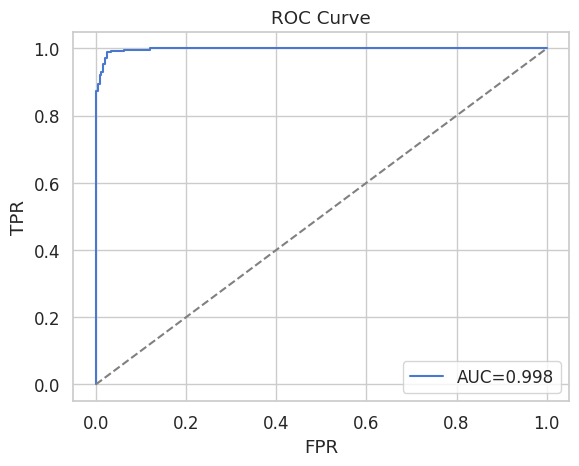

[INFO] Сохранено: mobilenet_openeyes.weights.h5


In [28]:
trainer = OpenEyesTrainer()

# Добавляем псевдоразметку, если нужно
trainer.set_pseudo_labels(pseudo_paths, pseudo_labels)

# Обучение
trainer.train(epochs=15)

# Оценка модели
trainer.evaluate()

# Сохранение весов
trainer.save("mobilenet_openeyes.weights.h5")


In [29]:
import os
import matplotlib.pyplot as plt

def save_classification_examples(trainer, output_dir="examples", top_k=1):
    os.makedirs(output_dir, exist_ok=True)

    if not trainer.model or not trainer.val_paths:
        print("[ERROR] Модель не обучена или нет валидационных данных.")
        return

    # 1. Предсказания
    y_scores = [trainer.predict_proba(p) for p in trainer.val_paths]
    y_true = trainer.y_val
    y_pred = [1 if s >= 0.5 else 0 for s in y_scores]  # Порог по умолчанию

    # 2. Расчёт ошибки
    errors = [abs(y - s) for y, s in zip(y_true, y_scores)]

    # 3. Лучшие и худшие индексы
    best_idxs = sorted(range(len(errors)), key=lambda i: errors[i])[:top_k]
    worst_idxs = sorted(range(len(errors)), key=lambda i: errors[i], reverse=True)[:top_k]

    def save_example(idx, tag):
        path = trainer.val_paths[idx]
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(4, 4))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(
            f"{tag}\nTrue: {y_true[idx]} | Pred: {y_pred[idx]} | Prob: {y_scores[idx]:.2f}"
        )
        fname = os.path.join(output_dir, f"{tag}_{idx}.jpg")
        plt.savefig(fname)
        plt.close()
        print(f"[SAVED] {fname}")

    # 4. Сохранение
    for i in best_idxs:
        save_example(i, "correct")

    for i in worst_idxs:
        save_example(i, "wrong")


In [30]:
save_classification_examples(trainer, output_dir="examples", top_k=2)

[SAVED] examples/correct_311.jpg
[SAVED] examples/correct_122.jpg
[SAVED] examples/wrong_170.jpg
[SAVED] examples/wrong_260.jpg


In [39]:
from glob import glob

# Предположим, trainer уже загружен с весами
paths = glob("/content/unzipped_dataset/EyesDataset/*.jpg")

for p in paths[:20]:
    score = trainer.predict_proba(p)
    print(f"{os.path.basename(p)}: {score:.4f}")

001633.jpg: 0.9621
003252.jpg: 0.4262
002360.jpg: 0.9289
000253.jpg: 0.9990
000549.jpg: 0.0047
003084.jpg: 0.9094
000868.jpg: 0.9628
001489.jpg: 0.0029
003682.jpg: 0.8780
002417.jpg: 0.0009
002969.jpg: 0.0002
001657.jpg: 0.0005
002303.jpg: 0.0249
001576.jpg: 0.6355
000107.jpg: 0.9982
001499.jpg: 0.9081
002696.jpg: 0.0003
002885.jpg: 0.0003
001422.jpg: 0.0052
000249.jpg: 0.8634
